In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
a = dir(datasets)

for text in a:
    if "mnist" in text.lower():
        print(text)

In [2]:
ROOT_DIR = "./dataset/"

# merges letters that have similar upper and lower cases, like C:c and W:w
SPLIT_DATA_BY = "bymerge"


def TRANSFORM_CALLABLE(img: Image.Image) -> torch.Tensor:
    return ToTensor()(img.transpose(Image.TRANSPOSE))

training_data = datasets.EMNIST(root=ROOT_DIR, split=SPLIT_DATA_BY, train=True, download=True, transform=TRANSFORM_CALLABLE)
testing_data = datasets.EMNIST(ROOT_DIR, split=SPLIT_DATA_BY, train=False, download=True, transform=TRANSFORM_CALLABLE)

print(training_data)
print(testing_data)

Dataset EMNIST
    Number of datapoints: 697932
    Root location: ./dataset/
    Split: Train
    StandardTransform
Transform: <function TRANSFORM_CALLABLE at 0x7ab450e52cb0>
Dataset EMNIST
    Number of datapoints: 116323
    Root location: ./dataset/
    Split: Test
    StandardTransform
Transform: <function TRANSFORM_CALLABLE at 0x7ab450e52cb0>


In [8]:
# output the index to char mapping
print(training_data.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0235, 0.0588, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0706,
          0.0706, 0.0196, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0353,
          0.3490, 0.5412, 0.0784, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

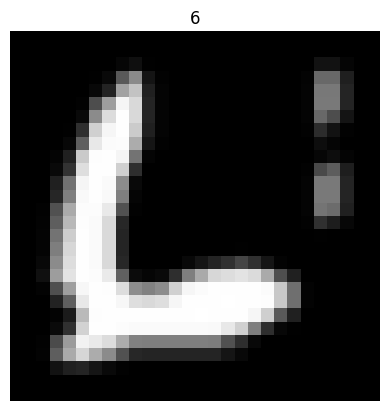

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0078, 0.2941, 0.6039, 0.0784, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0157, 0.4863, 0.9569, 0.3176, 0.0078, 0.0000,

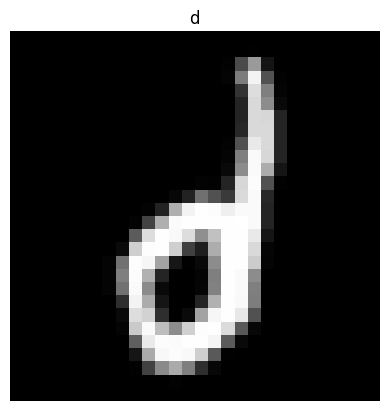

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078,
          0.0118, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0078, 0.0157, 0.0353, 0.1961, 0.4471,
          0.3176, 0.0863, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0275, 0.2980,
          0.4353, 0.0275, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.1255,
          0.1451, 0.0392, 0.0824, 0.3216, 0.4902, 0.5490,

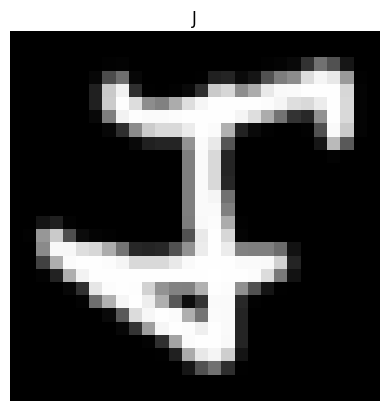

In [4]:
for i in range(3):
    rand_ind = torch.randint(len(training_data), size=(1,)).item()
    assert isinstance(rand_ind, int)

    img, label = training_data[rand_ind]
    img_class = training_data.classes[label]
    
    assert isinstance(img, torch.Tensor) and img.shape == (1, 28, 28)

    print(img)

    plt.imshow(img[0], cmap="gray")
    plt.title(img_class)
    plt.axis("off")
    plt.show()


In [ ]:
BATCH_SIZE = 64

training_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE)

X, y = next(iter(testing_dataloader))

print(X.shape, X.dtype)
print(y.shape, y.dtype)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
class TheModel(nn.Module):
    def __init__(self, output_dim):
        super().__init__() 
        self.sequential = nn.Sequential(
            nn.Conv2d(1, 16, 5, 2, 1),
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.MaxPool2d(2),

            nn.Conv2d(16, 16, 5, 2, 1),
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.MaxPool2d(2),

            # nn.Conv2d(16, 16, 3, 2, 1),
            # nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.MaxPool2d(2),

            # nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(576, output_dim),
            nn.LogSoftmax(1),
        )

    def forward(self, x):
        return self.sequential(x)


model = TheModel(len(training_data.classes)).to(device)
print(model)


In [ ]:
loss_func = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= 1e-3, momentum=0.9)

def train(dataloader, model, loss_func, optimizer):
    N = len(dataloader.dataset)
    model.train()

    for ind_batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        forward = model(X)
        loss = loss_func(forward, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if ind_batch % 100 == 0:
            loss_val, current = loss.item(), (ind_batch + 1) * len(X)
            print(f"loss: {loss_val:>7f}  {current:>5d}/{N:>5d}")


def test(dataloader, model, loss_func):
    N = len(dataloader.dataset)
    average_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            inference = model(X)
            average_loss += loss_func(inference, y).item()
            correct += (inference.argmax(1) == y).sum().item()
    
    average_loss /= len(dataloader)
    correct /= N

    print(f"% correct: {(100 * correct):>0.1f}  avg loss: {average_loss:>7f}")

In [ ]:
EPOCHS = 10
for ep in range(EPOCHS):
    print(f"Epoch {ep}\n---")
    train(training_dataloader, model, loss_func, optimizer)
    test(testing_dataloader, model, loss_func)

In [ ]:
torch.save(model.state_dict(), "weights (simpler model).pt")

In [ ]:
model = TheModel(len(training_data.classes))
model.load_state_dict(torch.load("weights (simpler model).pt"))
test(testing_dataloader, model.to("cuda"), loss_func)

In [ ]:
model = model.to("cpu")

model.eval()
empty_input = torch.zeros(1, 1, 28, 28).to("cpu")

torch.onnx.export(model, empty_input, "onnx_model.onnx", verbose=True)
